In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn.metrics
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest,f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

In [2]:
X=pd.read_csv('Xtrain.csv')
y=pd.read_csv('ytrain.csv')


X=pd.merge(X,y, how='inner', on='Trader') #on merge le vecteur type sur Xtrain
y=X.pop("type") #on met y au bon format série pour .fit


# Preprocessing :

In [3]:
def imputation(X):
    X=X.drop('Index', axis=1) # on supprime les colonnes inutiles
    X=X.drop('Share', axis=1)
    X=X.drop('Day', axis=1)
    X=X.drop("Trader",axis=1)
    
    index_bonnes_colonnes=X.columns[X.isna().sum()==0] #on supprime les colonnes avec des Nan -pour un essai rapide-
    X=X[index_bonnes_colonnes]
  
    return  X

X=imputation(X)

In [4]:
def encodage(y):
    code = {'NON HFT':0, 
            'MIX':1,
            'HFT':2}
    
    y=y.map(code)
    return y

y= encodage(y)

In [5]:
X_train, X_test,y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape

(74047, 21)

# Création du réseau de neurones :

In [6]:
pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2200      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1

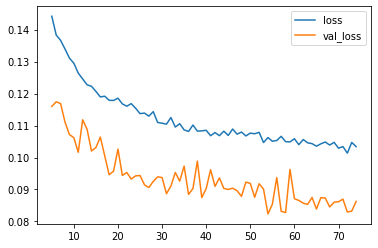

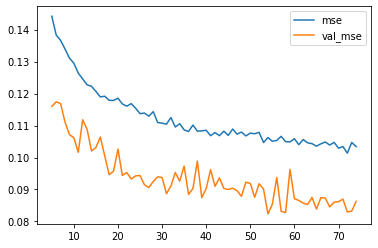

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

early_stopping = callbacks.EarlyStopping(min_delta=0.0005, patience = 20 , restore_best_weights=True)

#création du reseau de neurones
model=keras.Sequential([
    layers.Dense(units=100,activation='relu',input_shape=[21]),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    
    layers.Dense(units=100,activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=100,activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    
    layers.Dense(units=1)
                        ])

#fonction cout
model.compile(optimizer='adam',loss='mse', metrics=['mse'])  
model.summary()

record = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=50,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

history_df = pd.DataFrame(record.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['mse', 'val_mse']].plot()

print(("Best Validation Loss: {}" + "Best Validation Mse: {}").format(history_df['val_loss'].min(), 
              history_df['val_mse'].min()))

# Mise au bon format de la prediction :

In [9]:
X_true=pd.read_csv('Xtest.csv')

pred_longue=X_true[["Trader"]] #on met de côté l'ordre des traders dans le X_train.

X_true=imputation(X_true)

In [10]:
X_true = scaler.transform(X_true)
ypred=model.predict(X_true) 

In [12]:
pred_longue['type']=ypred #on rajoute le type prédit

In [13]:
pred_longue

,Trader,type
0,Adelaide,0.833091
1,Adelaide,1.198349
2,Adelaide,0.518957
3,Adelaide,1.088897
4,Adelaide,0.870098
...,...,...
85299,The Magic Mirror,0.989466
85300,The Magic Mirror,0.990927
85301,The Magic Mirror,0.974855
85302,The Magic Mirror,1.007948


In [14]:
submission_finale=pd.read_csv('example_submission.csv')

In [15]:
for i in range(submission_finale.shape[0]):
    individu = submission_finale["Trader"][i]

    temp=pred_longue[pred_longue["Trader"]==individu] #on ne garde que les lignes de l'individu d'intérêt


    nb_hft=sum(temp["type"]>1.5)
    nb_mix=sum((temp["type"]>0.5)&(temp["type"]<1.5))
    nb_non_hft=sum(temp["type"]<0.5)

    total=nb_hft+nb_mix+nb_non_hft

    if nb_hft/total>0.85 :
        categorie = "HFT"

    elif nb_mix/total>0.5 :
        categorie = "MIX"

    else:
        categorie="NON HFT"

    print(individu, categorie)
    submission_finale["type"][i]=categorie

Adelaide MIX
Alana NON HFT
Alcmene NON HFT
Alice HFT
Alices Sister NON HFT
Angel (Experiment 624) NON HFT
Annette MIX
Armoire MIX
Arthur/Wart MIX
Axe MIX
Baby Red Bird MIX
Backwoods Beagle MIX
Bacon Beagle NON HFT
Baileywick MIX
Bat Queen NON HFT
Becky NON HFT
Bent-Tail the Coyote NON HFT
Big Al NON HFT
Big Mama MIX
Bill Green MIX
Black Bart NON HFT
Bobble NON HFT
Bomber Beagle NON HFT
Bookseller NON HFT
Boomer NON HFT
Bowler Hat Guy NON HFT
Braddock MIX
Brer Bear NON HFT
Brudo Avarius HFT
Bruno the Dog NON HFT
Buck Leatherleaf HFT
Bucky Oryx-Antlerson NON HFT
Butch the Bulldog MIX
Butcher Boy NON HFT
Dallben NON HFT
Danny MIX
Dennis Avarius NON HFT
Digger the Mole NON HFT
Dijon the Thief MIX
Don Karnage HFT
Donald Duck MIX
Doug Dalmatian NON HFT
Dr. Delbert Doppler MIX
Dr. Facilier MIX
Dr. Joshua Sweet NON HFT
Dr. Teeth NON HFT
Duchess MIX
Duke of Weselton MIX
Dylan Dalmatian NON HFT
Edric Blight NON HFT
Elliott NON HFT
Emperor Belos NON HFT
Evinrude HFT
Fairy Mary MIX
Fidget MIX
Flas

In [16]:
submission_finale.to_csv('essai NN' ,index=False)